In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # Stack two Bidirectional LSTMs for better sequential feature extraction
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    lstm_out = Bidirectional(LSTM(128, return_sequences=False, dropout=0.4))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    output = Dense(1, activation='sigmoid')(lstm_out)

    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [4]:
import random

def load_precomputed_data(face_dir, flow_dir, edge_dir, label, condition_string, max_samples=15000):
    """Loads images in smaller batches to avoid memory overload."""
    x_data = []
    y_data = []
    count = 0

    print(f"\n🔄 Loading data from: {face_dir} (Label: {label}) - Filtering for '{condition_string}'")
    
    # Get list of relevant files
    face_files = [f for f in os.listdir(face_dir) if condition_string in f and f.endswith(".jpg")]

    if not face_files:
        print(f"⚠️ No '{condition_string}' images found in {face_dir}! Check filenames.")
        return np.array([]), np.array([])

    # Shuffle and limit to max_samples
    random.shuffle(face_files)
    face_files = face_files[:max_samples]

    batch_size = 1000  # Process in smaller batches
    for i in range(0, len(face_files), batch_size):
        batch_files = face_files[i:i+batch_size]

        batch_x = []
        for face_file in tqdm(batch_files, desc=f"Processing {face_dir} [{i}/{len(face_files)}]", unit="img"):
            base_name = os.path.splitext(face_file)[0].replace("_face", "")

            face_path = os.path.join(face_dir, face_file)
            flow_path = os.path.join(flow_dir, base_name + "_flow.jpg")
            edge_path = os.path.join(edge_dir, base_name + "_edges.jpg")

            if os.path.exists(face_path) and os.path.exists(flow_path) and os.path.exists(edge_path):
                try:
                    # Load images and resize
                    face_img = cv2.resize(cv2.imread(face_path), (299, 299))
                    flow_img = cv2.resize(cv2.imread(flow_path), (299, 299))
                    edge_img = cv2.resize(cv2.imread(edge_path), (299, 299))

                    # Normalize and convert to float32 to save memory
                    face_img = face_img.astype(np.float32) / 255.0
                    flow_img = flow_img.astype(np.float32) / 255.0
                    edge_img = edge_img.astype(np.float32) / 255.0

                    # Concatenate into a 9-channel image
                    combined_input = np.concatenate((face_img, flow_img, edge_img), axis=-1)

                    batch_x.append(combined_input)
                    y_data.append(label)

                except Exception as e:
                    print(f"⚠️ Error processing {face_file}: {e}")

        if batch_x:
            x_data.extend(batch_x)
        count += len(batch_x)

    if count == 0:
        print(f"⚠️ No valid samples found in {face_dir}. Please check file names and paths!\n")

    print(f"✅ Finished loading {count} images from {face_dir}.\n")
    return np.array(x_data, dtype=np.float32), np.array(y_data, dtype=np.int8)  # Convert to smaller dtype

# Load in smaller batches
print("🔄 Starting to load precomputed datasets...\n")
real_x, real_y = load_precomputed_data("E:/dataset/real", "E:/dataset/optical_flow", "E:/dataset/edges", label=0, condition_string="", max_samples=50000)
fake_x, fake_y = load_precomputed_data("E:/dataset/fake", "E:/dataset/optical_flow", "E:/dataset/edges", label=1, condition_string="", max_samples=50000)

# Ensure we loaded data
if real_x.size == 0 or fake_x.size == 0:
    print("❌ ERROR: No valid images loaded! Fix errors before continuing.")
    exit()

# **Use np.memmap to write data in chunks to avoid RAM overuse**
save_path = "E:/dataset/preprocessed_data_Exp4.npz"
print("💾 Saving preprocessed data in chunks to avoid memory issues...")

# Define shapes
total_samples = real_x.shape[0] + fake_x.shape[0]
image_shape = (299, 299, 9)

# Create a memory-mapped file
x_data_memmap = np.memmap(save_path.replace(".npz", "_x.dat"), dtype=np.float32, mode="w+", shape=(total_samples, *image_shape))
y_data_memmap = np.memmap(save_path.replace(".npz", "_y.dat"), dtype=np.int8, mode="w+", shape=(total_samples,))

# Write in chunks
x_data_memmap[:real_x.shape[0]] = real_x
x_data_memmap[real_x.shape[0]:] = fake_x
y_data_memmap[:real_y.shape[0]] = real_y
y_data_memmap[real_y.shape[0]:] = fake_y

# Flush to disk
del x_data_memmap, y_data_memmap  # Ensure it's saved before creating NPZ file

# Save final NPZ file with memory-efficient data
np.savez_compressed(save_path, x=np.memmap(save_path.replace(".npz", "_x.dat"), dtype=np.float32, mode="r", shape=(total_samples, *image_shape)), 
                                  y=np.memmap(save_path.replace(".npz", "_y.dat"), dtype=np.int8, mode="r", shape=(total_samples,)))

print("✅ Data saved successfully!")

🔄 Starting to load precomputed datasets...


🔄 Loading data from: E:/dataset/real (Label: 0) - Filtering for ''


Processing E:/dataset/real [49000/50000]: 100%|██████████| 1000/1000 [07:12<00:00,  2.31img/s]


✅ Finished loading 4875 images from E:/dataset/real.


🔄 Loading data from: E:/dataset/fake (Label: 1) - Filtering for ''


Processing E:/dataset/fake [49000/50000]: 100%|██████████| 1000/1000 [06:46<00:00,  2.46img/s]


✅ Finished loading 4960 images from E:/dataset/fake.

💾 Saving preprocessed data in chunks to avoid memory issues...
✅ Data saved successfully!


In [4]:
# Load precomputed dataset
save_path = "E:/dataset/preprocessed_data_Exp4.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path)

# Extract x_data and y_data
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Verify shapes
print(f"📊 Train/Test Split:")
print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

📂 Loading precomputed dataset from E:/dataset/preprocessed_data_Exp4.npz...
✅ Loaded dataset: 9835 samples.
📊 Train/Test Split:
  x_train: (7868, 299, 299, 9), y_train: (7868,)
  x_test: (1967, 299, 299, 9), y_test: (1967,)


In [5]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,232,577 (8.52 MB)

 Trainable params: 2,232,065 (8.51 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 931s 4s/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5161 - loss: 0.6930
Epoch 1: val_accuracy improved from -inf to 0.49568, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5161 - loss: 0.6930 - val_accuracy: 0.4957 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 2/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5465 - loss: 0.6922
Epoch 2: val_accuracy improved from 0.49568 to 0.50432, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5466 - loss: 0.6922 - val_accuracy: 0.5043 - val_loss: 0.6918 - learning_rate: 1.0000e-04
Epoch 3/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6271 - loss: 0.6885
Epoch 3: val_accuracy improved from 0.50432 to 0.74123, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6275 - loss: 0.6884 - val_accuracy: 0.7412 - val_loss: 0.6807 - learning_rate: 1.0000e-04
Epoch 4/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7455 - loss: 0.6709
Epoch 4: val_accuracy improved from 0.74123 to 0.86172, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7456 - loss: 0.6708 - val_accuracy: 0.8617 - val_loss: 0.6306 - learning_rate: 1.0000e-04
Epoch 5/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8005 - loss: 0.6138
Epoch 5: val_accuracy did not improve from 0.86172
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8006 - loss: 0.6135 - val_accuracy: 0.5241 - val_loss: 0.5681 - learning_rate: 1.0000e-04
Epoch 6/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8483 - loss: 0.4991
Epoch 6: val_accuracy did not improve from 0.86172
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8484 - loss: 0.4987 - val_accuracy: 0.5653 - val_loss: 0.5418 - learning_rate: 1.0000e-04
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8716 - loss: 0.3833
Epoch 7: val_accuracy improved from 0.86172 to 0.91357, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8717 - loss: 0.3832 - val_accuracy: 0.9136 - val_loss: 0.3072 - learning_rate: 1.0000e-04
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8763 - loss: 0.3199
Epoch 8: val_accuracy did not improve from 0.91357
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8763 - loss: 0.3199 - val_accuracy: 0.8866 - val_loss: 0.2946 - learning_rate: 1.0000e-04
Epoch 9/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8878 - loss: 0.2772
Epoch 9: val_accuracy did not improve from 0.91357
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8878 - loss: 0.2772 - val_accuracy: 0.8958 - val_loss: 0.2598 - learning_rate: 1.0000e-04
Epoch 10/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8947 - loss: 0.2624
Epoch 10: val_accuracy improved from 0.91357 to 0.92120, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8946 - loss: 0.2624 - val_accuracy: 0.9212 - val_loss: 0.2190 - learning_rate: 1.0000e-04
Epoch 11/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8920 - loss: 0.2615
Epoch 11: val_accuracy improved from 0.92120 to 0.92476, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8920 - loss: 0.2614 - val_accuracy: 0.9248 - val_loss: 0.2049 - learning_rate: 1.0000e-04
Epoch 12/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9011 - loss: 0.2380
Epoch 12: val_accuracy improved from 0.92476 to 0.92679, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9011 - loss: 0.2380 - val_accuracy: 0.9268 - val_loss: 0.1953 - learning_rate: 1.0000e-04
Epoch 13/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9015 - loss: 0.2325
Epoch 13: val_accuracy improved from 0.92679 to 0.92832, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9015 - loss: 0.2325 - val_accuracy: 0.9283 - val_loss: 0.1917 - learning_rate: 1.0000e-04
Epoch 14/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8959 - loss: 0.2419
Epoch 14: val_accuracy did not improve from 0.92832
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8959 - loss: 0.2419 - val_accuracy: 0.9181 - val_loss: 0.1986 - learning_rate: 1.0000e-04
Epoch 15/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8939 - loss: 0.2433
Epoch 15: val_accuracy did not improve from 0.92832
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8939 - loss: 0.2432 - val_accuracy: 0.9243 - val_loss: 0.1933 - learning_rate: 1.0000e-04
Epoch 16/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8965 - loss: 0.2399
Epoch 16: val_accuracy improved from 0.92832 to 0.92883, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8965 - loss: 0.2399 - val_accuracy: 0.9288 - val_loss: 0.1870 - learning_rate: 1.0000e-04
Epoch 17/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8990 - loss: 0.2391
Epoch 17: val_accuracy did not improve from 0.92883
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8990 - loss: 0.2391 - val_accuracy: 0.9288 - val_loss: 0.1862 - learning_rate: 1.0000e-04
Epoch 18/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8970 - loss: 0.2374
Epoch 18: val_accuracy improved from 0.92883 to 0.93137, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8970 - loss: 0.2374 - val_accuracy: 0.9314 - val_loss: 0.1807 - learning_rate: 1.0000e-04
Epoch 19/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8941 - loss: 0.2395
Epoch 19: val_accuracy improved from 0.93137 to 0.93238, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8941 - loss: 0.2395 - val_accuracy: 0.9324 - val_loss: 0.1797 - learning_rate: 1.0000e-04
Epoch 20/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8972 - loss: 0.2419
Epoch 20: val_accuracy did not improve from 0.93238
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8972 - loss: 0.2419 - val_accuracy: 0.9293 - val_loss: 0.1814 - learning_rate: 1.0000e-04
Epoch 21/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9017 - loss: 0.2343
Epoch 21: val_accuracy did not improve from 0.93238
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9017 - loss: 0.2343 - val_accuracy: 0.9293 - val_loss: 0.1808 - learning_rate: 1.0000e-04
Epoch 22/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9076 - loss: 0.2211
Epoch 22: val_accuracy did not improve from 0.93238
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9076 - loss: 0.2212 - val_accuracy: 0.9283 - val_loss: 0.1847 - learning_rate: 1.00

246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9001 - loss: 0.2304 - val_accuracy: 0.9349 - val_loss: 0.1732 - learning_rate: 1.0000e-04
Epoch 25/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8955 - loss: 0.2364
Epoch 25: val_accuracy did not improve from 0.93493
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8955 - loss: 0.2364 - val_accuracy: 0.9197 - val_loss: 0.1905 - learning_rate: 1.0000e-04
Epoch 26/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9043 - loss: 0.2243
Epoch 26: val_accuracy improved from 0.93493 to 0.93543, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9043 - loss: 0.2243 - val_accuracy: 0.9354 - val_loss: 0.1716 - learning_rate: 1.0000e-04
Epoch 27/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9012 - loss: 0.2222
Epoch 27: val_accuracy did not improve from 0.93543
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9013 - loss: 0.2222 - val_accuracy: 0.9354 - val_loss: 0.1696 - learning_rate: 1.0000e-04
Epoch 28/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9116 - loss: 0.2114
Epoch 28: val_accuracy improved from 0.93543 to 0.93645, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9116 - loss: 0.2115 - val_accuracy: 0.9365 - val_loss: 0.1690 - learning_rate: 1.0000e-04
Epoch 29/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9076 - loss: 0.2191
Epoch 29: val_accuracy did not improve from 0.93645
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9076 - loss: 0.2191 - val_accuracy: 0.9359 - val_loss: 0.1669 - learning_rate: 1.0000e-04
Epoch 30/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9064 - loss: 0.2207
Epoch 30: val_accuracy improved from 0.93645 to 0.93696, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9064 - loss: 0.2207 - val_accuracy: 0.9370 - val_loss: 0.1675 - learning_rate: 1.0000e-04
Epoch 31/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9010 - loss: 0.2273
Epoch 31: val_accuracy improved from 0.93696 to 0.93849, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9011 - loss: 0.2273 - val_accuracy: 0.9385 - val_loss: 0.1652 - learning_rate: 1.0000e-04
Epoch 32/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9042 - loss: 0.2186
Epoch 32: val_accuracy did not improve from 0.93849
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9043 - loss: 0.2186 - val_accuracy: 0.9283 - val_loss: 0.1731 - learning_rate: 1.0000e-04
Epoch 33/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8991 - loss: 0.2264
Epoch 33: val_accuracy did not improve from 0.93849
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8991 - loss: 0.2263 - val_accuracy: 0.9365 - val_loss: 0.1651 - learning_rate: 1.0000e-04
Epoch 34/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9012 - loss: 0.2282
Epoch 34: val_accuracy did not improve from 0.93849
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9012 - loss: 0.2281 - val_accuracy: 0.9309 - val_loss: 0.1680 - learning_rate: 1.00

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9174 - loss: 0.2075 - val_accuracy: 0.9400 - val_loss: 0.1601 - learning_rate: 1.0000e-04
Epoch 36/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9148 - loss: 0.2027
Epoch 36: val_accuracy improved from 0.94001 to 0.94052, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9147 - loss: 0.2028 - val_accuracy: 0.9405 - val_loss: 0.1591 - learning_rate: 1.0000e-04
Epoch 37/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9154 - loss: 0.2149
Epoch 37: val_accuracy improved from 0.94052 to 0.94103, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9154 - loss: 0.2149 - val_accuracy: 0.9410 - val_loss: 0.1580 - learning_rate: 1.0000e-04
Epoch 38/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9104 - loss: 0.2054
Epoch 38: val_accuracy did not improve from 0.94103
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9104 - loss: 0.2055 - val_accuracy: 0.9217 - val_loss: 0.1896 - learning_rate: 1.0000e-04
Epoch 39/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9158 - loss: 0.1989
Epoch 39: val_accuracy did not improve from 0.94103
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9157 - loss: 0.1990 - val_accuracy: 0.9365 - val_loss: 0.1647 - learning_rate: 1.0000e-04
Epoch 40/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9170 - loss: 0.2035
Epoch 40: val_accuracy improved from 0.94103 to 0.94154, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9169 - loss: 0.2035 - val_accuracy: 0.9415 - val_loss: 0.1548 - learning_rate: 1.0000e-04
Epoch 41/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9117 - loss: 0.2039
Epoch 41: val_accuracy did not improve from 0.94154
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9116 - loss: 0.2039 - val_accuracy: 0.9354 - val_loss: 0.1595 - learning_rate: 1.0000e-04
Epoch 42/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9135 - loss: 0.2066
Epoch 42: val_accuracy did not improve from 0.94154
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9136 - loss: 0.2066 - val_accuracy: 0.9395 - val_loss: 0.1550 - learning_rate: 1.0000e-04
Epoch 43/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9122 - loss: 0.2149
Epoch 43: val_accuracy improved from 0.94154 to 0.94357, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9123 - loss: 0.2148 - val_accuracy: 0.9436 - val_loss: 0.1528 - learning_rate: 1.0000e-04
Epoch 44/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9122 - loss: 0.2139
Epoch 44: val_accuracy did not improve from 0.94357
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9122 - loss: 0.2138 - val_accuracy: 0.9395 - val_loss: 0.1553 - learning_rate: 1.0000e-04
Epoch 45/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9201 - loss: 0.1986
Epoch 45: val_accuracy did not improve from 0.94357
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9200 - loss: 0.1986 - val_accuracy: 0.9420 - val_loss: 0.1510 - learning_rate: 1.0000e-04
Epoch 46/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9186 - loss: 0.2016
Epoch 46: val_accuracy improved from 0.94357 to 0.94560, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9186 - loss: 0.2016 - val_accuracy: 0.9456 - val_loss: 0.1486 - learning_rate: 1.0000e-04
Epoch 47/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9165 - loss: 0.1972
Epoch 47: val_accuracy did not improve from 0.94560
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9166 - loss: 0.1972 - val_accuracy: 0.9431 - val_loss: 0.1537 - learning_rate: 1.0000e-04
Epoch 48/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9188 - loss: 0.1966
Epoch 48: val_accuracy did not improve from 0.94560
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9188 - loss: 0.1966 - val_accuracy: 0.9451 - val_loss: 0.1456 - learning_rate: 1.0000e-04
Epoch 49/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9123 - loss: 0.2044
Epoch 49: val_accuracy improved from 0.94560 to 0.94662, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9123 - loss: 0.2044 - val_accuracy: 0.9466 - val_loss: 0.1435 - learning_rate: 1.0000e-04
Epoch 50/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9151 - loss: 0.2024
Epoch 50: val_accuracy improved from 0.94662 to 0.94814, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9151 - loss: 0.2024 - val_accuracy: 0.9481 - val_loss: 0.1428 - learning_rate: 1.0000e-04
Epoch 51/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9209 - loss: 0.1959
Epoch 51: val_accuracy improved from 0.94814 to 0.94967, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9209 - loss: 0.1959 - val_accuracy: 0.9497 - val_loss: 0.1422 - learning_rate: 1.0000e-04
Epoch 52/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9175 - loss: 0.2004
Epoch 52: val_accuracy did not improve from 0.94967
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9176 - loss: 0.2004 - val_accuracy: 0.9476 - val_loss: 0.1408 - learning_rate: 1.0000e-04
Epoch 53/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9225 - loss: 0.1870
Epoch 53: val_accuracy improved from 0.94967 to 0.95119, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9224 - loss: 0.1872 - val_accuracy: 0.9512 - val_loss: 0.1404 - learning_rate: 1.0000e-04
Epoch 54/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9227 - loss: 0.1842
Epoch 54: val_accuracy did not improve from 0.95119
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9226 - loss: 0.1842 - val_accuracy: 0.9456 - val_loss: 0.1408 - learning_rate: 1.0000e-04
Epoch 55/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9241 - loss: 0.1787
Epoch 55: val_accuracy did not improve from 0.95119
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9240 - loss: 0.1788 - val_accuracy: 0.9451 - val_loss: 0.1402 - learning_rate: 1.0000e-04
Epoch 56/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9244 - loss: 0.1829
Epoch 56: val_accuracy improved from 0.95119 to 0.95425, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9244 - loss: 0.1829 - val_accuracy: 0.9542 - val_loss: 0.1365 - learning_rate: 1.0000e-04
Epoch 57/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9153 - loss: 0.1969
Epoch 57: val_accuracy did not improve from 0.95425
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9153 - loss: 0.1969 - val_accuracy: 0.9517 - val_loss: 0.1363 - learning_rate: 1.0000e-04
Epoch 58/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9185 - loss: 0.1964
Epoch 58: val_accuracy did not improve from 0.95425
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9185 - loss: 0.1964 - val_accuracy: 0.9502 - val_loss: 0.1350 - learning_rate: 1.0000e-04
Epoch 59/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9310 - loss: 0.1837
Epoch 59: val_accuracy did not improve from 0.95425
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9309 - loss: 0.1837 - val_accuracy: 0.9441 - val_loss: 0.1385 - learning_rate: 1.00

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9267 - loss: 0.1806 - val_accuracy: 0.9563 - val_loss: 0.1284 - learning_rate: 1.0000e-04
Epoch 64/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9221 - loss: 0.1852
Epoch 64: val_accuracy did not improve from 0.95628
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9221 - loss: 0.1852 - val_accuracy: 0.9532 - val_loss: 0.1291 - learning_rate: 1.0000e-04
Epoch 65/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9246 - loss: 0.1789
Epoch 65: val_accuracy did not improve from 0.95628
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9246 - loss: 0.1788 - val_accuracy: 0.9558 - val_loss: 0.1260 - learning_rate: 1.0000e-04
Epoch 66/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9226 - loss: 0.1815
Epoch 66: val_accuracy did not improve from 0.95628
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9226 - loss: 0.1815 - val_accuracy: 0.9563 - val_loss: 0.1246 - learning_rate: 1.00

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9307 - loss: 0.1660 - val_accuracy: 0.9578 - val_loss: 0.1224 - learning_rate: 1.0000e-04
Epoch 69/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9286 - loss: 0.1763
Epoch 69: val_accuracy did not improve from 0.95780
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9286 - loss: 0.1763 - val_accuracy: 0.9532 - val_loss: 0.1264 - learning_rate: 1.0000e-04
Epoch 70/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9295 - loss: 0.1719
Epoch 70: val_accuracy did not improve from 0.95780
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9295 - loss: 0.1718 - val_accuracy: 0.9532 - val_loss: 0.1245 - learning_rate: 1.0000e-04
Epoch 71/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9315 - loss: 0.1697
Epoch 71: val_accuracy did not improve from 0.95780
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9314 - loss: 0.1698 - val_accuracy: 0.9578 - val_loss: 0.1193 - learning_rate: 1.00

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9321 - loss: 0.1627 - val_accuracy: 0.9603 - val_loss: 0.1169 - learning_rate: 1.0000e-04
Epoch 73/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9270 - loss: 0.1731
Epoch 73: val_accuracy did not improve from 0.96035
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9270 - loss: 0.1730 - val_accuracy: 0.9461 - val_loss: 0.1375 - learning_rate: 1.0000e-04
Epoch 74/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9269 - loss: 0.1759
Epoch 74: val_accuracy did not improve from 0.96035
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9270 - loss: 0.1759 - val_accuracy: 0.9548 - val_loss: 0.1212 - learning_rate: 1.0000e-04
Epoch 75/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9330 - loss: 0.1609
Epoch 75: val_accuracy did not improve from 0.96035
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9330 - loss: 0.1609 - val_accuracy: 0.9558 - val_loss: 0.1184 - learning_rate: 1.00

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9330 - loss: 0.1707 - val_accuracy: 0.9609 - val_loss: 0.1120 - learning_rate: 5.0000e-05
Epoch 79/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9325 - loss: 0.1639
Epoch 79: val_accuracy did not improve from 0.96085
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9325 - loss: 0.1639 - val_accuracy: 0.9568 - val_loss: 0.1136 - learning_rate: 5.0000e-05
Epoch 80/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9321 - loss: 0.1666
Epoch 80: val_accuracy improved from 0.96085 to 0.96187, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9322 - loss: 0.1666 - val_accuracy: 0.9619 - val_loss: 0.1102 - learning_rate: 5.0000e-05
Epoch 81/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9334 - loss: 0.1630
Epoch 81: val_accuracy did not improve from 0.96187
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9334 - loss: 0.1629 - val_accuracy: 0.9609 - val_loss: 0.1090 - learning_rate: 5.0000e-05
Epoch 82/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9301 - loss: 0.1616
Epoch 82: val_accuracy did not improve from 0.96187
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9301 - loss: 0.1616 - val_accuracy: 0.9619 - val_loss: 0.1093 - learning_rate: 5.0000e-05
Epoch 83/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9335 - loss: 0.1649
Epoch 83: val_accuracy did not improve from 0.96187
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9335 - loss: 0.1649 - val_accuracy: 0.9568 - val_loss: 0.1108 - learning_rate: 5.00

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9384 - loss: 0.1444 - val_accuracy: 0.9629 - val_loss: 0.1069 - learning_rate: 5.0000e-05
Epoch 85/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9416 - loss: 0.1538
Epoch 85: val_accuracy did not improve from 0.96289
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9416 - loss: 0.1538 - val_accuracy: 0.9619 - val_loss: 0.1068 - learning_rate: 5.0000e-05
Epoch 86/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9401 - loss: 0.1519
Epoch 86: val_accuracy did not improve from 0.96289
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9401 - loss: 0.1519 - val_accuracy: 0.9624 - val_loss: 0.1072 - learning_rate: 5.0000e-05
Epoch 87/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9370 - loss: 0.1615
Epoch 87: val_accuracy did not improve from 0.96289
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9370 - loss: 0.1615 - val_accuracy: 0.9578 - val_loss: 0.1086 - learning_rate: 5.00

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9484 - loss: 0.1339 - val_accuracy: 0.9634 - val_loss: 0.1030 - learning_rate: 5.0000e-05
Epoch 90/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9376 - loss: 0.1537
Epoch 90: val_accuracy did not improve from 0.96340
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9376 - loss: 0.1537 - val_accuracy: 0.9609 - val_loss: 0.1047 - learning_rate: 5.0000e-05
Epoch 91/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9401 - loss: 0.1452
Epoch 91: val_accuracy improved from 0.96340 to 0.96441, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9401 - loss: 0.1453 - val_accuracy: 0.9644 - val_loss: 0.1017 - learning_rate: 5.0000e-05
Epoch 92/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9326 - loss: 0.1545
Epoch 92: val_accuracy improved from 0.96441 to 0.96543, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9326 - loss: 0.1544 - val_accuracy: 0.9654 - val_loss: 0.1009 - learning_rate: 5.0000e-05
Epoch 93/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9386 - loss: 0.1523
Epoch 93: val_accuracy did not improve from 0.96543
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9386 - loss: 0.1523 - val_accuracy: 0.9614 - val_loss: 0.1026 - learning_rate: 5.0000e-05
Epoch 94/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9384 - loss: 0.1448
Epoch 94: val_accuracy improved from 0.96543 to 0.96594, saving model to best_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9384 - loss: 0.1448 - val_accuracy: 0.9659 - val_loss: 0.0995 - learning_rate: 5.0000e-05
Epoch 95/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9403 - loss: 0.1437
Epoch 95: val_accuracy did not improve from 0.96594
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9403 - loss: 0.1436 - val_accuracy: 0.9598 - val_loss: 0.1027 - learning_rate: 5.0000e-05
Epoch 96/100
243/246 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9393 - loss: 0.1505
Epoch 96: val_accuracy did not improve from 0.96594
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9393 - loss: 0.1503 - val_accuracy: 0.9634 - val_loss: 0.0992 - learning_rate: 5.0000e-05
Epoch 97/100
244/246 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9443 - loss: 0.1385
Epoch 97: val_accuracy did not improve from 0.96594
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9443 - loss: 0.1385 - val_accuracy: 0.9573 - val_loss: 0.1033 - learning_rate: 5.00

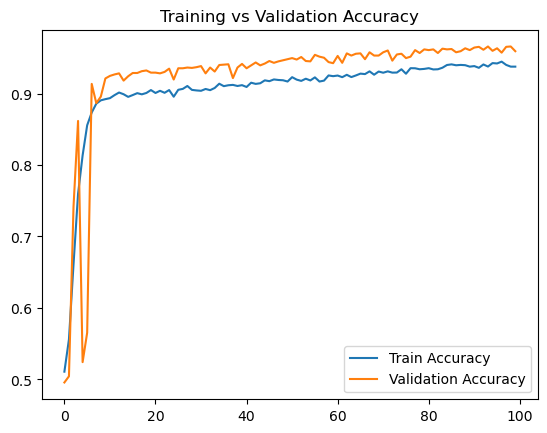

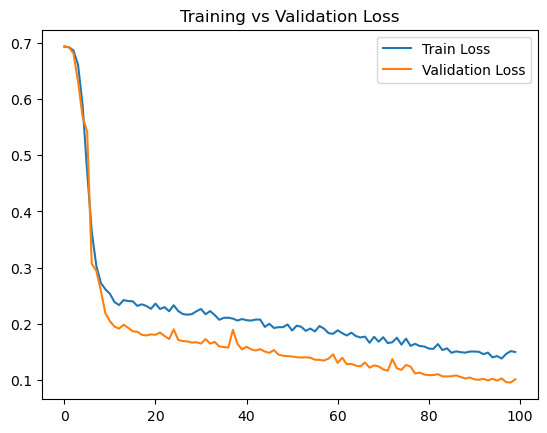

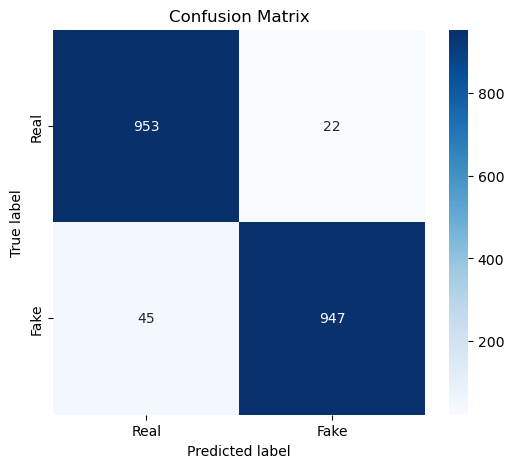

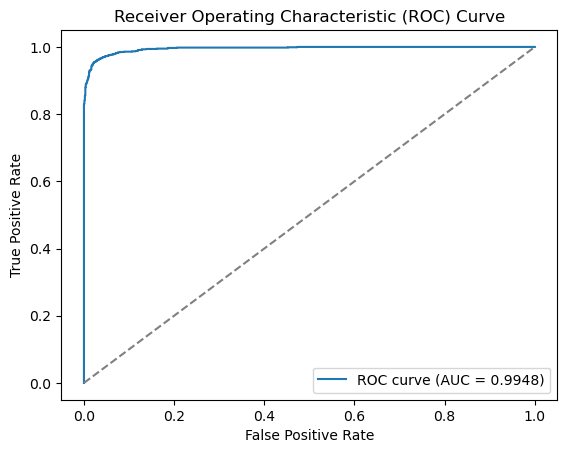

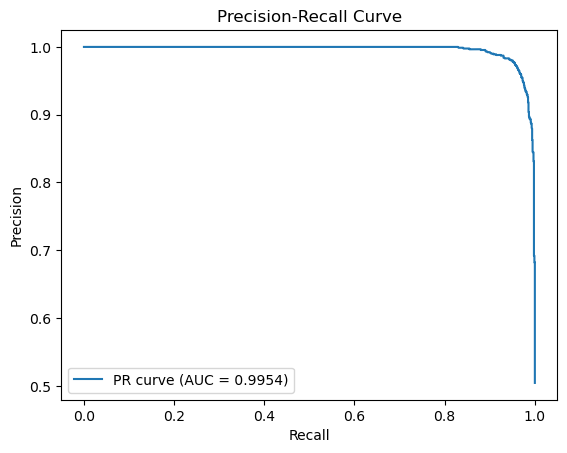

Accuracy Score: 0.9659
ROC AUC Score: 0.9948
Recall Score: 0.9546
Precision Score: 0.9773
F1 Score: 0.9658
PR AUC Score: 0.9954
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       975
           1       0.98      0.95      0.97       992

    accuracy                           0.97      1967
   macro avg       0.97      0.97      0.97      1967
weighted avg       0.97      0.97      0.97      1967



In [6]:
# Train the Model
train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32)